<a href="https://colab.research.google.com/github/Jojo-Rabbit/pix2pix/blob/master/Pix_2_Pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Dataset Loading

In [ ]:
! kaggle datasets download ktaebum/anime-sketch-colorization-pair

100% 11.6G/11.6G [04:02<00:00, 66.8MB/s]
100% 11.6G/11.6G [04:02<00:00, 51.5MB/s]


In [ ]:
! unzip anime-sketch-colorization-pair.zip

In [ ]:
! pip install albumentations==0.4.6

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import os
from torch.utils.data import Dataset
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

Discriminator Model

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.block1 = nn.Sequential(nn.Conv2d(in_channels=in_channels*2,
                                              out_channels=features[0],
                                              kernel_size=4,
                                              stride=2,
                                              padding=1,
                                              padding_mode='reflect'),
                                    nn.LeakyReLU(0.2))

        self.block2 = nn.Sequential(nn.Conv2d(in_channels=features[0],
                                              out_channels=features[1],
                                              kernel_size=4,
                                              stride=2,
                                              bias=False,
                                              padding_mode='reflect'),
                                    nn.BatchNorm2d(features[1]),
                                    nn.LeakyReLU(0.2))

        self.block3 = nn.Sequential(nn.Conv2d(in_channels=features[1],
                                              out_channels=features[2],
                                              kernel_size=4,
                                              stride=2,
                                              bias=False,
                                              padding_mode='reflect'),
                                    nn.BatchNorm2d(features[2]),
                                    nn.LeakyReLU(0.2))

        self.block4 = nn.Sequential(nn.Conv2d(in_channels=features[2],
                                              out_channels=features[3],
                                              kernel_size=4,
                                              stride=1,
                                              bias=False,
                                              padding_mode='reflect'),
                                    nn.BatchNorm2d(features[3]),
                                    nn.LeakyReLU(0.2))

        self.block5 = nn.Sequential(nn.Conv2d(in_channels=features[3],
                                              out_channels=1,
                                              kernel_size=4,
                                              stride=1,
                                              padding=1,
                                              padding_mode='reflect'))

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        return torch.sigmoid(x)

In [ ]:
def test_1():
  x = torch.randn((1, 3, 256, 256))
  y = torch.randn((1, 3, 256, 256))
  model = Discriminator()
  preds = model(x, y)
  print(preds.shape)

test_1()

torch.Size([1, 1, 26, 26])


Generator Model

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channel, out_channel, down=True, act='relu', drop=False):
        super().__init__()
        self.block = nn.Sequential(nn.Conv2d(in_channels=in_channel,
                                             out_channels=out_channel,
                                             kernel_size=4,
                                             stride=2,
                                             padding=1,
                                             bias=False,
                                             padding_mode='reflect') if down
                                   else nn.ConvTranspose2d(in_channels=in_channel,
                                                           out_channels=out_channel,
                                                           kernel_size=4,
                                                           stride=2,
                                                           padding=1,
                                                           bias=False),
                                   nn.BatchNorm2d(out_channel),
                                   nn.ReLU() if act == 'relu'
                                   else nn.LeakyReLU(0.2))
        self.drop = drop
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.block(x)
        return self.dropout(x) if self.drop else x


class Generator(nn.Module):
    def __init__(self, in_channel=3, feature=64):
        super().__init__()
        self.initial = nn.Sequential(nn.Conv2d(in_channels=in_channel,
                                               out_channels=feature,
                                               kernel_size=4,
                                               stride=2,
                                               padding=1,
                                               padding_mode='reflect'),
                                     nn.LeakyReLU(0.2))

        self.down1 = Block(feature, feature * 2, True, 'Leaky', False)
        self.down2 = Block(feature * 2, feature * 4, True, 'Leaky', False)
        self.down3 = Block(feature * 4, feature * 8, True, 'Leaky', False)
        self.down4 = Block(feature * 8, feature * 8, True, 'Leaky', False)
        self.down5 = Block(feature * 8, feature * 8, True, 'Leaky', False)
        self.down6 = Block(feature * 8, feature * 8, True, 'Leaky', False)

        self.bottleneck = nn.Sequential(nn.Conv2d(in_channels=feature * 8,
                                                  out_channels=feature * 8,
                                                  kernel_size=4,
                                                  stride=2,
                                                  padding=1,
                                                  padding_mode='reflect'),
                                        nn.ReLU())

        self.up1 = Block(feature * 8, feature * 8, False, 'relu', True)
        self.up2 = Block(feature * 8 * 2, feature * 8, False, 'relu', True)
        self.up3 = Block(feature * 8 * 2, feature * 8, False, 'relu', True)
        self.up4 = Block(feature * 8 * 2, feature * 8, False, 'relu', False)
        self.up5 = Block(feature * 8 * 2, feature * 4, False, 'relu', False)
        self.up6 = Block(feature * 4 * 2, feature * 2, False, 'relu', False)
        self.up7 = Block(feature * 2 * 2, feature, False, 'relu', False)
        self.final = nn.Sequential(nn.ConvTranspose2d(in_channels=feature * 2,
                                                      out_channels=in_channel,
                                                      kernel_size=4,
                                                      stride=2,
                                                      padding=1),
                                   nn.Tanh())

    def forward(self, x):
        d1 = self.initial(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)

        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        final = self.final(torch.cat([up7, d1], 1))

        return final

In [ ]:
def test_2():
  x = torch.randn((1, 3, 256, 256))
  model = Generator()
  output = model(x)
  print(output.shape)

test_2()

torch.Size([1, 3, 256, 256])


Dataset Loader

In [ ]:
transform_only_input = A.Compose(
    [
      A.Resize(height=256, width=256),
      A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
      ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

class AnimeDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.list_files = os.listdir(self.root_dir)
        
    def __len__(self):
        return len(self.list_files)
    
    def __getitem__(self, index):
        image_file = self.list_files[index]
        image_path = os.path.join(self.root_dir, image_file)
        image = np.array(Image.open(image_path))
        input_image = image[:, 512:, :]
        target_image = image[:, :512, :]
        
        input_image = transform_only_input(image=input_image)["image"]
        target_image = transform_only_mask(image=target_image)["image"]
        
        return input_image, target_image

Hyperparameters

In [9]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ROOT_DIR = '/content/data/data/train'
VAL_DIR = '/content/data/data/val'
LEARNING_RATE = 2e-4
BATCH_SIZE = 16
NUM_WORKERS = 2
IMG_SIZE = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
NUM_EPOCHS = 200
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_DISC = "disc.pth.tar"
CHECKPOINT_GEN = "gen.pth.tar"

In [ ]:
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

In [ ]:
def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [ ]:
def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
    gen.train()

In [ ]:
torch.backends.cudnn.benchmark = True

Training

In [ ]:
def train(disc, gen, loader, opt_disc, opt_gen, bce, l1, g_scaler, d_scaler):
    loop = tqdm(loader, leave=True)
    
    for idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            D_fake = disc(x, y_fake.detach())
            D_real = disc(x, y)
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_loss = (D_real_loss + D_fake_loss) / 2
            
        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()
        
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1_loss = l1(y_fake, y)*L1_LAMBDA
            G_loss = G_fake_loss + L1_loss
        
        gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()
        
        if idx % 10 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
            )

In [ ]:
disc = Discriminator(in_channels=CHANNELS_IMG).to(DEVICE)
gen = Generator(in_channel=CHANNELS_IMG).to(DEVICE)
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
BCE = nn.BCEWithLogitsLoss()
L1 = nn.L1Loss()

if LOAD_MODEL:
    load_checkpoint(
        CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE,
    )
    load_checkpoint(
        CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE,
    )

train_dataset = AnimeDataset(ROOT_DIR)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()
    
val_dataset = AnimeDataset(VAL_DIR)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

In [ ]:
for epoch in range(NUM_EPOCHS):
        train(disc, gen, train_loader, opt_disc, opt_gen, BCE, L1, g_scaler, d_scaler)
        
        if SAVE_MODEL and epoch%5 == 0:
            save_checkpoint(disc, opt_disc, filename=CHECKPOINT_DISC)
            save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
            
        save_some_examples(gen, val_loader, epoch, folder='/content/output')

100%|██████████| 889/889 [18:40<00:00,  1.26s/it, D_fake=0.5, D_real=0.713]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 889/889 [18:03<00:00,  1.22s/it, D_fake=0.5, D_real=0.731]


=> Saving checkpoint
=> Saving checkpoint


 62%|██████▏   | 553/889 [11:09<06:45,  1.21s/it, D_fake=0.5, D_real=0.731]

Results

In [10]:
import torchvision.transforms as transforms

loader = transforms.Compose(
    [
      transforms.Resize((512, 512)),
      transforms.ToTensor(),
    ]
)

def load_image(image_name):
  img = Image.open(image_name).convert('RGB')
  img = loader(img).unsqueeze(0)
  return img.to(DEVICE)

In [7]:
import matplotlib.pyplot as plt

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = torch.squeeze(image, axis=0)
  
  image = image.cpu().detach().numpy()
  image = image.transpose(1, 2, 0)
  
  plt.imshow(image, )
  if title:
    plt.title(title)

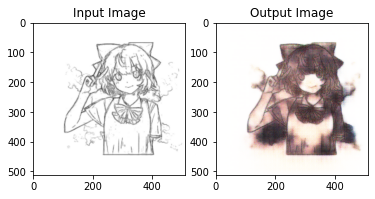

In [11]:
input_img = load_image("/content/output/input_0.png")
output_img = load_image("/content/output/y_gen_0.png")

plt.subplot(1, 2, 1)
imshow(input_img, "Input Image")

plt.subplot(1, 2, 2)
imshow(output_img, "Output Image")

In [ ]:
# val_dataset = AnimeDataset(VAL_DIR)
# val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
folder='/content/data'
x, y = next(iter(val_loader))
x, y = x.to(DEVICE), y.to(DEVICE)
gen.eval()
with torch.no_grad():
  y_fake = gen(x)
  y_fake = y_fake * 0.5 + 0.5  # remove normalization#
  save_image(y_fake, folder + f"/y_gen_new.png")
  save_image(x * 0.5 + 0.5, folder + f"/input_new.png")
  save_image(y * 0.5 + 0.5, folder + f"/label_new.png")